<a href="https://colab.research.google.com/github/ShuichiroTsuda/Kaggle_Liverpool_Ion_Switching/blob/master/xgb1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression, Ridge, SGDRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, f1_score, mean_absolute_error, make_scorer

import xgboost as xgb

from functools import partial
import scipy as sp

import time
import datetime

import gc

In [0]:
import json
from google.colab import drive
import os

class ColabKaggle:

    base = 'gdrive/My Drive/'

    def __init__(self):
        drive.mount('gdrive')

    def load_api_key(self, path):
        """
        example of path: path = 'Colab Notebooks/Kaggle/API_setup/kaggle.json'

        """
        path = self.base + path
        with open(path) as f:
            kaggle_api_key = json.load(f)

        filename = "/root/.kaggle/kaggle.json"
        os.makedirs(os.path.dirname(filename), exist_ok=True)

        with open(filename, 'w') as f:
            json.dump(kaggle_api_key, f)

        os.chmod(filename, 600)

        print('API key loaded.')

ck = ColabKaggle()
ck.load_api_key('Colab Notebooks/Kaggle/API_setup/kaggle.json')

In [0]:
train = pd.read_pickle('gdrive/My Drive/Colab Notebooks/Kaggle/Liverpool_Ion_Switching/train1.pkl')
test = pd.read_pickle('gdrive/My Drive/Colab Notebooks/Kaggle/Liverpool_Ion_Switching/test1.pkl')

In [0]:
y = train['open_channels']
col = [c for c in train.columns if c not in ['time', 'open_channels', 'group']]

seed_random = 42

In [0]:
def MacroF1Metric(preds, dtrain):
    labels = dtrain.get_label()
    preds = np.round(np.clip(preds, 0, 10)).astype(int)
    score = f1_score(labels, preds, average = 'macro')
    return ('MacroF1Metric', score, True)

In [19]:
%%time
X_train, X_valid, y_train, y_valid = train_test_split(train[col], y, test_size=0.3, random_state=seed_random)
train_set = xgb.DMatrix(X_train, y_train)
val_set = xgb.DMatrix(X_valid, y_valid)
del X_train, X_valid, y_train, y_valid
gc.collect()

params_xgb = {'colsample_bytree': 0.375,
              'learning_rate': 0.1,
              'max_depth': 8, 
              'subsample': 1, 
              'objective':'reg:squarederror',
              'eval_metric':'rmse'}

modelx = xgb.train(
    params_xgb, 
    train_set, 
    num_boost_round=2000, 
    evals=[(train_set, 'train'), (val_set, 'val')], 
    verbose_eval=100, 
    early_stopping_rounds=100)

del train_set, val_set
gc.collect()

[0]	train-rmse:3.12676	val-rmse:3.12637
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[100]	train-rmse:0.159116	val-rmse:0.162812
[200]	train-rmse:0.155562	val-rmse:0.161328
[300]	train-rmse:0.153142	val-rmse:0.160611
[400]	train-rmse:0.15115	val-rmse:0.16022
[500]	train-rmse:0.149297	val-rmse:0.159934
[600]	train-rmse:0.147754	val-rmse:0.159812
[700]	train-rmse:0.146198	val-rmse:0.159646
[800]	train-rmse:0.144923	val-rmse:0.159569
[900]	train-rmse:0.143534	val-rmse:0.159531
[1000]	train-rmse:0.142203	val-rmse:0.159461
[1100]	train-rmse:0.140824	val-rmse:0.159424
[1200]	train-rmse:0.139621	val-rmse:0.15938
Stopping. Best iteration:
[1195]	train-rmse:0.139671	val-rmse:0.159378

CPU times: user 11h 3min 31s, sys: 14.9 s, total: 11h 3min 46s
Wall time: 2h 53min 17s


In [20]:
y_xgb_pred = modelx.predict(xgb.DMatrix(test[col]))
y_pred_train_xgb = modelx.predict(xgb.DMatrix(train[col]))
gc.collect()

4

In [0]:
np.save('gdrive/My Drive/Colab Notebooks/Kaggle/Liverpool_Ion_Switching/xgb1',y_pred_train_xgb)

In [22]:
print('XGB score {0:.4f}'.format(np.mean(f1_score(y, np.round(np.clip(y_pred_train_xgb,0,10)).astype(int), average="macro"))))

XGB score 0.9483


In [0]:
def plot_cm(y_true, y_pred, title):
    figsize=(14,14)
    y_pred = y_pred.astype(int)
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)


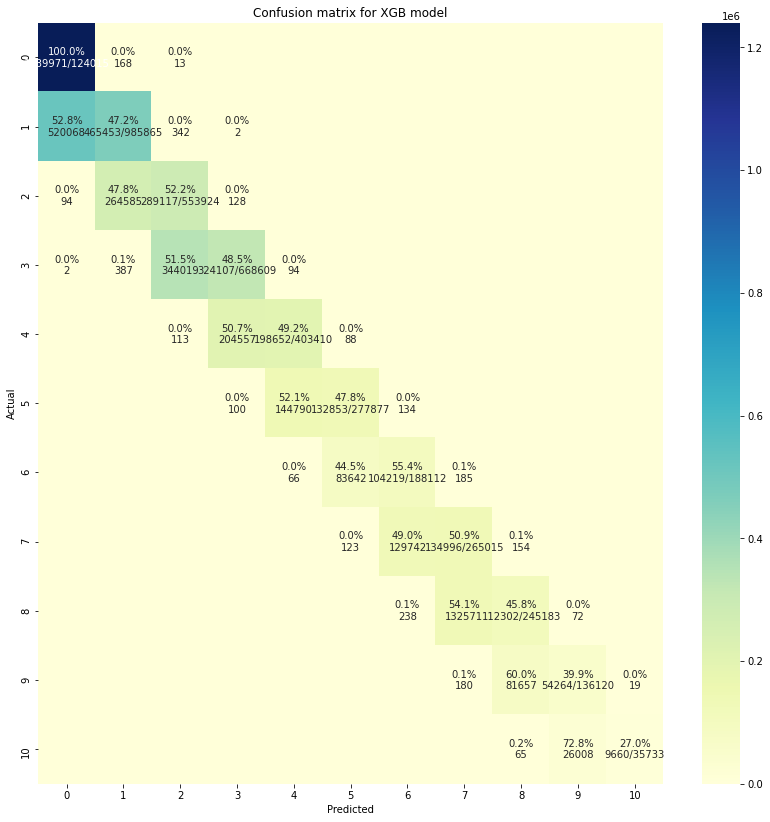

In [24]:
plot_cm(y, y_pred_train_xgb, 'Confusion matrix for XGB model')